In [10]:
import pandas as pd
import sqlite3
import geopandas as gpd

In [3]:
conn = sqlite3.connect("tmp/dump1.db")
df = pd.read_sql(
    "SELECT * FROM train_position",
    conn,
    parse_dates=["creation_time"],
    dtype={
        "relation": "category",
        "menetvonal": "category",
        "elviraid": "category",
        "trainnumber": "category",
        "line": "category"
    },
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152609 entries, 0 to 152608
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   creation_time  152609 non-null  datetime64[ns]
 1   delay          152431 non-null  float64       
 2   lat            152609 non-null  float64       
 3   lon            152609 non-null  float64       
 4   line           8229 non-null    category      
 5   relation       152609 non-null  category      
 6   menetvonal     152609 non-null  category      
 7   elviraid       152609 non-null  category      
 8   trainnumber    152609 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(3)
memory usage: 5.9 MB


In [6]:
df.to_pickle('dump1.pkl')

In [7]:
df.groupby('trainnumber').count().sort_values(by='creation_time',ascending=False).head()

/var/folders/lt/gqr91__s30l64fglfjp_cdzh0000gn/T/ipykernel_81087/3821720711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('trainnumber').count().sort_values(by='creation_time',ascending=False).head()


,creation_time,delay,lat,lon,line,relation,menetvonal,elviraid
trainnumber,,,,,,,,
559696,449,449,449,449,0,449,449,449
55192,449,449,449,449,0,449,449,449
55656,449,449,449,449,0,449,449,449
556256,449,449,449,449,0,449,449,449
55723,449,449,449,449,0,449,449,449


In [40]:
rand_train = df[df['trainnumber'] == '559696']

In [43]:
rand_train.set_index('creation_time', inplace=True)

<Axes: xlabel='lon'>

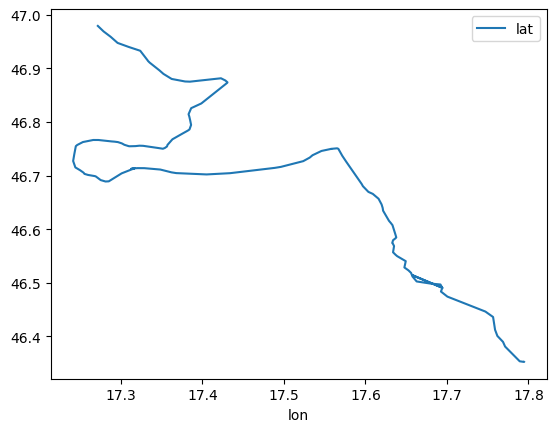

In [46]:
rand_train.plot(x='lon', y='lat')

In [76]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs='EPSG:4326'
)

In [73]:
utm_crs = gdf.estimate_utm_crs()
gdf = gdf.to_crs(utm_crs)

In [74]:
gdf = gdf.drop_duplicates(subset=['geometry', 'elviraid'])

In [75]:
pd.options.mode.copy_on_write = True

In [107]:
gdf['timestamp'] = pd.to_datetime(gdf['creation_time'])
gdf = gdf.set_index('timestamp')

In [108]:
gdf['prev_geometry'] = gdf.groupby('elviraid')['geometry'].shift()

In [109]:
gdf['distance_m'] = gdf.geometry.distance(gdf['prev_geometry']).fillna(0)

<Axes: >

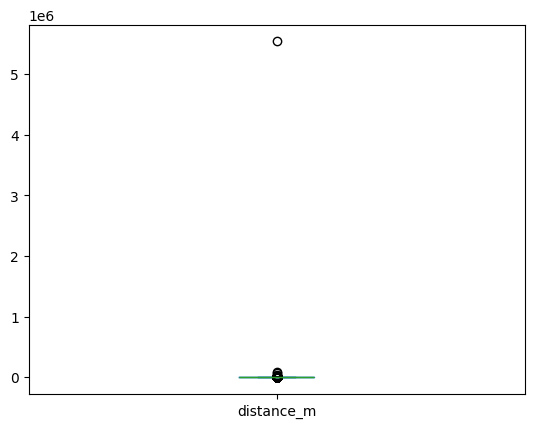

In [110]:
gdf['distance_m'].plot(kind='box')

In [111]:
gdf.sort_values(by='distance_m', ascending=False).head(10)

,creation_time,delay,lat,lon,line,relation,menetvonal,elviraid,trainnumber,geometry,prev_geometry,distance_m
timestamp,,,,,,,,,,,,
2025-05-28 18:52:43,2025.05.28 18:52:43,0.0,47.183510,18.425430,None,Székesfehérvár - Kőbánya-Kispest,MAV,7621664_250528,553521,POINT (1213862.126 5268816.711),POINT (-505646.9 0),5.542305e+06
2025-05-28 18:31:03,2025.05.28 18:31:03,2.0,46.199010,18.828373,154,Székesfehérvár - Baja,MAV,7608926_250528,558396,POINT (1258133.694 5163318.027),POINT (1231925.279 5238709.735),7.981723e+04
2025-05-28 18:09:23,2025.05.28 18:09:23,0.0,46.692576,17.288541,30,Győr - Pécs,MAV,8330267_250528,559603,POINT (1133611.829 5204465.646),POINT (1116914.686 5266370.453),6.411708e+04
2025-05-28 17:53:03,2025.05.28 17:53:03,7.0,47.733790,17.464440,1,Wien Hbf - Chop,MAV,8018422_250528,55149,POINT (1134425.861 5321513.564),POINT (1108580.13 5338908.583),3.115427e+04
2025-05-28 18:44:03,2025.05.28 18:44:03,3.0,47.379779,18.914246,40,Dunaújváros - Budapest-Déli,MAV,8330340_250528,554253,POINT (1248056.393 5295224.075),POINT (1239974.116 5267124.548),2.923879e+04
2025-05-28 17:42:03,2025.05.28 17:42:03,2.0,47.369915,18.901155,40,Dunaújváros - Budapest-Déli,MAV,8330339_250528,554243,POINT (1247210.162 5294002.498),POINT (1240060.579 5267311.367),2.763210e+04
2025-05-28 17:51:03,2025.05.28 17:51:03,6.0,47.913553,17.147644,1,Wien Hbf - Chop,MAV,8018422_250528,55149,POINT (1108580.13 5338908.583),POINT (1130808.712 5323942.034),2.679753e+04
2025-05-28 18:52:43,2025.05.28 18:52:43,0.0,47.719915,17.489270,1U,Salzburg Hbf - Budapest-Keleti,MAV,8008922_250528,5512067,POINT (1136455.662 5320178.257),POINT (1118190.069 5332873.424),2.224408e+04
2025-05-28 17:03:03,2025.05.28 17:03:03,4.0,48.508800,21.230286,80,Miskolc-Tiszai - Hidasnémeti,MAV,7622407_250528,555326,POINT (1402438.02 5445520.931),POINT (1397387.179 5424080.452),2.202737e+04


In [113]:
gdf.reset_index(inplace=True)
gdf = gdf.sort_values(by=['elviraid', 'timestamp'])
gdf['time_diff'] = gdf.groupby('elviraid')['timestamp'].diff().dt.total_seconds().fillna(0)

In [112]:
gdf['distance_m'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.25      93.916614
0.50     301.274890
0.75     678.972904
0.90    1300.226098
0.95    1700.644540
0.99    2648.599412
Name: distance_m, dtype: float64

In [116]:
gdf['speed_kph'] = (gdf['distance_m'] / gdf['time_diff'].replace(0, 1) * 3.6)

In [125]:
upper_98_speed_limit = gdf['speed_kph'].quantile(0.98)

In [126]:
gdf = gdf[gdf['speed_kph'] < upper_98_speed_limit]

In [128]:
import folium
from folium import plugins
import pandas as pd

# Your data: a DataFrame with 'latitude', 'longitude', 'speed_kph'
# Assume it's already filtered to 1 point per time/train (or aggregated as needed)

# Normalize speed for color scaling
def speed_to_color(speed, min_speed, max_speed):
    # Simple linear gradient: green (slow) → red (fast)
    ratio = (speed - min_speed) / (max_speed - min_speed + 1e-6)
    r = int(255 * ratio)
    g = int(255 * (1 - ratio))
    b = 0
    return f'#{r:02x}{g:02x}{b:02x}'

# Define color bounds
min_speed = gdf['speed_kph'].min()
max_speed = gdf['speed_kph'].max()

# Create map centered around the data
m = folium.Map(location=[gdf['lat'].mean(), gdf['lon'].mean()], zoom_start=10)

# Add colored points
for _, row in gdf.iterrows():
    color = speed_to_color(row['speed_kph'], min_speed, max_speed)
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=f"Speed: {row['speed_kph']:.1f} km/h",
    ).add_to(m)

m.save("colored_speed_map.html")



In [136]:
gdf.groupby('relation')['speed_kph'].agg('mean').sort_values(ascending=True).head(10)

relation
Hegyeshalom - Bratislava-N. M.                       0.000000
Debrecen - Nyírábrány                                0.000000
Záhony - Szolnok                                     0.000000
Gyékényes - Balatonszentgyörgy                       0.000000
Tököl - Dunaharaszti külső                           0.004813
Gödöllő - Cinkota                                    0.005842
Hegyeshalom - Szombathely                            0.097322
Szeged - Subotica                                    9.978668
Szeged vasútállomás - Szeged, Rókus vasútállomás    13.861509
Vásárosnamény - Mátészalka                          15.287807
Name: speed_kph, dtype: float64

In [143]:
szeged_szabadka = gdf[gdf['relation'] == 'szeged_szabadka']
szeged_szabadka.set_index('timestamp', inplace=True)

<Axes: >

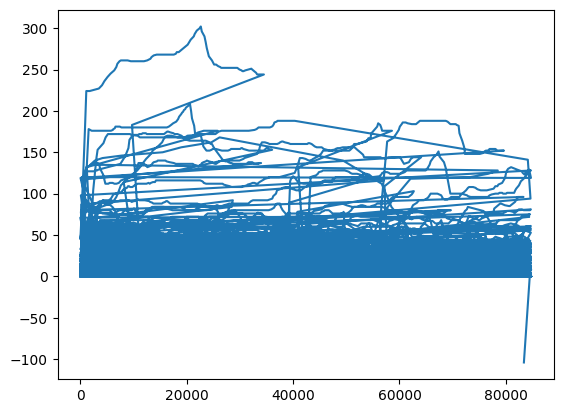

In [155]:
gdf['delay'].rolling(4).sum().plot(kind='line')

In [156]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 83056 entries, 54586 to 83383
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      83056 non-null  datetime64[ns]
 1   creation_time  83056 non-null  object        
 2   delay          82888 non-null  float64       
 3   lat            83056 non-null  float64       
 4   lon            83056 non-null  float64       
 5   line           2694 non-null   object        
 6   relation       83056 non-null  object        
 7   menetvonal     83056 non-null  object        
 8   elviraid       83056 non-null  object        
 9   trainnumber    83056 non-null  object        
 10  geometry       83056 non-null  geometry      
 11  prev_geometry  82053 non-null  geometry      
 12  distance_m     83056 non-null  float64       
 13  time_diff      83056 non-null  float64       
 14  speed_kph      83056 non-null  float64       
dtypes: datetime6

In [157]:
gdf.to_file('train_position.geojson', driver='GeoJSON')

ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.

In [158]:
gdf.groupby('elviraid')['timestamp'].count().sort_values(ascending=False).head(10)

elviraid
7620596_250528        276
7609031_250528        274
7622951_250528        271
7621462_250528        268
8018434_250528        263
7623123_250528        260
7623105_250528        259
7622950_250528        255
1188243#905_250528    253
7622513_250528        252
Name: timestamp, dtype: int64

In [159]:
random_train = gdf[gdf['elviraid'] == '7620596_250528']

In [160]:
random_train

,timestamp,creation_time,delay,lat,lon,line,relation,menetvonal,elviraid,trainnumber,geometry,prev_geometry,distance_m,time_diff,speed_kph
276,2025-05-28 16:14:40,2025.05.28 16:14:40,0.0,47.49791,19.02565,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1254747.137 5309420.468),None,0.000000,0.0,0.000000
3516,2025-05-28 16:31:35,2025.05.28 16:31:35,0.0,47.49790,19.02566,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1254748.034 5309419.456),POINT (1254747.137 5309420.468),1.351939,1015.0,0.004795
9316,2025-05-28 16:42:18,2025.05.28 16:42:18,6.0,47.49781,19.02569,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1254751.592 5309409.762),POINT (1254748.034 5309419.456),10.326169,643.0,0.057814
9534,2025-05-28 16:42:38,2025.05.28 16:42:38,6.0,47.49717,19.02585,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1254772.883 5309340.306),POINT (1254751.592 5309409.762),72.646475,20.0,13.076365
10152,2025-05-28 16:43:38,2025.05.28 16:43:38,8.0,47.49291,19.02774,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1254976.66 5308886.076),POINT (1254772.883 5309340.306),497.845515,60.0,29.870731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83516,2025-05-28 18:56:03,2025.05.28 18:56:03,1.0,46.71309,17.31405,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1135318.709 5206950.614),POINT (1135324.583 5206953.485),6.538200,20.0,1.176876
83836,2025-05-28 18:56:43,2025.05.28 18:56:43,1.0,46.71262,17.31258,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1135211.981 5206886.48),POINT (1135318.709 5206950.614),124.515500,40.0,11.206395
84211,2025-05-28 18:57:23,2025.05.28 18:57:23,1.0,46.70531,17.30217,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1134503.077 5205990.215),POINT (1135211.981 5206886.48),1142.731712,40.0,102.845854
84539,2025-05-28 18:58:03,2025.05.28 18:58:03,1.0,46.69772,17.29424,None,Budapest-Déli - Keszthely,MAV,7620596_250528,55876,POINT (1133986.718 5205083.06),POINT (1134503.077 5205990.215),1043.818176,40.0,93.943636


In [161]:
random_train.set_index('timestamp', inplace=True)

<Axes: title={'center': 'Speed over Time for Train 7620596_250528'}, xlabel='timestamp'>

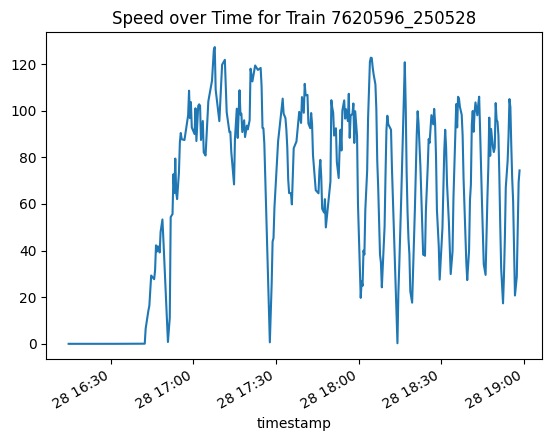

In [171]:
random_train['speed_kph'].rolling('2min').agg('mean').plot(kind='line', title='Speed over Time for Train 7620596_250528')

In [174]:
import folium
import numpy as np

# Sort by train and time
random_train = random_train.sort_values(['elviraid', 'timestamp'])

# Create a folium map
m = folium.Map(location=[random_train['lat'].mean(), random_train['lon'].mean()], zoom_start=10)

# Normalize speed for color scaling
min_speed = random_train['speed_kph'].min()
max_speed = random_train['speed_kph'].max()

def speed_to_color(speed, min_speed, max_speed):
    # Green (slow) to Red (fast)
    ratio = (speed - min_speed) / (max_speed - min_speed + 1e-6)
    g = int(255 * ratio)
    r = int(255 * (1 - ratio))
    b = 0
    return f'#{r:02x}{g:02x}{b:02x}'

# Iterate over each train
for elviraid, group in random_train.groupby('elviraid'):
    group = group.sort_values('timestamp')
    coords = list(zip(group['lat'], group['lon']))
    speeds = group['speed_kph'].values

    # Draw line segments between consecutive points
    for i in range(1, len(coords)):
        segment = [coords[i-1], coords[i]]
        speed = (speeds[i-1] + speeds[i]) / 2  # Average speed for the segment
        color = speed_to_color(speed, min_speed, max_speed)
        folium.PolyLine(
            locations=segment,
            color=color,
            weight=4,
            opacity=0.8,
            popup=f"Speed: {speed:.1f} km/h"
        ).add_to(m)

m.save("speed_segments_map.html")

In [175]:
import folium
import numpy as np

# Sort by train and time
gdf = gdf.sort_values(['elviraid', 'timestamp'])

# Build a list of all segments with their speed
segments = []
for elviraid, group in gdf.groupby('elviraid'):
    group = group.sort_values('timestamp')
    coords = list(zip(group['lat'], group['lon']))
    speeds = group['speed_kph'].values
    for i in range(1, len(coords)):
        segment = (coords[i-1], coords[i])
        speed = (speeds[i-1] + speeds[i]) / 2  # Average speed for this segment in this train
        segments.append((segment, speed))

# Group segments by their coordinates (start, end) and compute average speed
from collections import defaultdict

segment_speeds = defaultdict(list)
for segment, speed in segments:
    segment_speeds[segment].append(speed)

# Compute average speed for each unique segment
avg_segments = []
for segment, speeds in segment_speeds.items():
    avg_speed = np.mean(speeds)
    avg_segments.append((segment, avg_speed))

# Normalize speed for color scaling
all_speeds = [s for _, s in avg_segments]
min_speed = min(all_speeds)
max_speed = max(all_speeds)

def speed_to_color(speed, min_speed, max_speed):
    # Green (slow) to Red (fast)
    ratio = (speed - min_speed) / (max_speed - min_speed + 1e-6)
    r = int(255 * ratio)
    g = int(255 * (1 - ratio))
    b = 0
    return f'#{r:02x}{g:02x}{b:02x}'

# Create a folium map
m = folium.Map(location=[gdf['lat'].mean(), gdf['lon'].mean()], zoom_start=10)

# Plot each unique segment colored by its average speed
for segment, avg_speed in avg_segments:
    color = speed_to_color(avg_speed, min_speed, max_speed)
    folium.PolyLine(
        locations=segment,
        color=color,
        weight=4,
        opacity=0.8,
        popup=f"Avg Speed: {avg_speed:.1f} km/h"
    ).add_to(m)

m.save("all_trains_avg_speed_segments_map.html")

In [77]:
import polyline

polyline.decode(r"og|yGonrkBqHdn@UnFCjRKtDg@fE_AlDqBbEaAlAqAhAk\\hTsBfAwCr@sBLep@JoFVkkBz]aD|@cDzA{x@hd@ii@lPaG|AgBRkCBkaA_Cwa@?sEd@is@nLiD`A_CtAqu@zp@mCnCgC`Dqd@jq@s|CluGuAjCiAxAmB`ByB`A}B`@aC?wgAwO_DWaDR{Br@aC`BeBrB_AfBgAzCg@|Be@rDkTnvCi@nDm@xBy@pBsAxBiBjBwA|@eMvFeCv@_J~A{CfAqGpD}GvGuCbByCp@}b@bHoEzAoJnFaVlPkCvCeGjJiBhBwAz@{Br@aDRaSsBoPM}Cg@mHoD{Bs@_DO_BL}A`@yAp@oB~AkAxAyFjJkBhBkEjDqBrBaPtU}BnCol@za@aD~AiCp@yCVmDKgCe@iH}B_C[mb@UsNa@iCTeBb@cUzJcCx@eD\\yGF}Ba@kCmAiZsU{DaCoCiAgCs@kC_@kCOqBHgCn@eUpK}Af@_BTeSb@qa@cBcDF{DdAer@~W_ChAaKhGcCbAsbCjq@iDl@mCP{VOmDTyo@zKeCv@{KxEgCr@iC\\cHXiBX}Af@yBpA}}@`p@mCxBkAxAuAlCgOr_@eAbBkArAuAbAeBz@wJrDmL~Bas@lRgnAnc@kkAx_@yj@~U}wCdbAqq@lNmB`A{BfCmArCu@tDShD@bBJnBlG~d@pFp^`BrGtDjKhAlCd[po@~ClFpCxD|CdDdDrC~t@zi@zEfFtB|CfBbDrBvEvBvGfdArpDxBrKvApK|NnvAxDj`@|g@h_FbAfMtLd`DT~IB`FSrNwHjoCu@fU}A|l@WnFi@tG{@jGoAtGmj@fqB{AfHiA`Iq@zJOlLi@bfBDzHZhId@zG|@~HxAtIlAjFpBbHfCzG|AjDrDvG`G~HhBnBfmBrqBtClDn@fAp@bB^zA\\|BJtABlDStCYdBm@zBmMh_@{BpEeBxBkB|Aa[|SiClCsAdCk@|Ao@`CwNl{@{@nDoAzCuAhBoA~@cJjDwDhCca@n_@kT`XwBnBiCvAcDx@uy@xImFXyDKicDiSwA_@qAm@yG_G_^{f@sNyNoA{AqA}B{AuEm@_EYeGaBw{@DiHb@wG`MeqAxEsu@d@}DjAqFpIeV|BcElJ{KbB_CrBkDlH}NzAaF`AsFZyDp@wLHcDAuDYaGeFal@Q{FHeF\\}EjA{KvOqxAx@kEdA{DdIyTt@{DR_GW_E{@}Dq@}AeA_B_OeOeBuAgCoA{Ac@gBUyWk@qD]}Bi@}CiA{EyC}g@gg@c~AmoBsCaC{BkAsMgEoBi@gEk@}ToAmFGkHVizAtLmM`BwZtFuCVgF?}Ei@uEmAiD}AaFmDeCcC_BoBap@afA{F}HoHyHuh@sa@mNkJaWyRqNcMgdC{lB{AeAcBm@{AUmABoBf@kDvBo[tXcBhCq@lBuAjFe@tDEfDLbCXxBjB`Kdc@rwEVhE@nBOjEg@xDkPxz@sPv}@eBrHgAxC_AlBaDpEcEbDsv@ha@yFbD}CdCoYpZ}CpBuNnEgD~AyCfCsYhZwClCcNvIeOpIqAl@oCp@acAvPwC|@_EhBoFtDuCpC{QfTgCpD{@bBojAbyCwAdCyAjB{CbCkt@lf@{a@lY}fAb`A}C~AwJxCsDzAyi@lZqBxAaXnU_FvEyAjBcC|DgOzX_C`FyAlEmQ|k@wBdGyfBboE{BzEeClDuDhDwo@vf@iBjBuAjBgIjNeCjC{CrBaEvAsh@lLqGfBwl@jMuJbBuEb@wEAuGw@sHwAiEoAiEyB{K}GkM_FsDeAkB[sDYqD@sD\\ce@|HiPlBiGdAyEhAiBp@aE|B}DdDkEpFaIjN}ChEyDrDyB|AeDdBwMxFsJxCqGrAuZrEaf@zLqFl@c`@tBgDr@_ClA_CxB{JpPyK~NwF|Fq@b@cDlAm`@rLqCf@iA?oB]iL_EyCYuBRkPxGaCRaBKy@W}BsAwBuC{Toi@_AcBeAkAgAy@uBeAch@aVkDoAoDu@ayBi\\yIgAivAiNkDSo\\bAegBdJoObBabB|VaGdA_IrBoKxDwgBpx@aMdF{Ch@{EdBi{@f`@wAbAoM~LkBxCo@fBoChL{Ufw@zUgw@t@yCb@iC\\yDHqC?iCMuD}@iHyAyIm@kC_tGynSqJi[}V_w@s_@mlA{CiKqBmJiA}H_AyJuj@ojHwBc[gJ_lAiCsZs`AybMw@{Fw@aEyAqFwB}Fcj@uhAiAuBgBkCwA}AuBiBuuDcrCgEqCoE{BqEiBwEwAsHyAiJu@gcIyYaJgAuHmByH{CiH_EkJqHuzC_mCgCcC{BaDcB}Dq@eCe@aCi@sFK_G\\_HfH_p@n@wHJaEEiEWkEYgCy@mEkA}DaMm[sC_GgDeFiDsDqEgDwDiB_EmAwCe@mRq@ei@{@uRMseDeFyG[eH_AiHgBiG}BqkFuaCyFqB{WiGuc@uH_X_Eo_HmkA_FgAyDkAsIsDkF_DsGgFuEsEoFyGw}G}zJ{CsDeD{B_D_AsBO{ABoC`@}Ad@yAr@qAbAyCtDiB~DqA~Em@pDUjCaBb`BBtGNjCv@fHrBvOv@pEpB`JhEpQ",
)

[(46.35272, 17.79448),
 (46.35425, 17.78693),
 (46.35436, 17.78573),
 (46.35438, 17.78263),
 (46.35444, 17.78172),
 (46.35464, 17.78072),
 (46.35496, 17.77985),
 (46.35553, 17.77887),
 (46.35586, 17.77848),
 (46.35627, 17.77811),
 (46.36097, 17.77796),
 (46.35756, 17.77854),
 (46.3572, 17.7793),
 (46.35694, 17.77988),
 (46.35687, 17.78775),
 (46.35681, 17.78895),
 (46.35669, 17.80629),
 (46.35175, 17.8071),
 (46.35144, 17.80792),
 (46.35098, 17.81718),
 (46.34501, 17.82395),
 (46.34222, 17.82524),
 (46.34175, 17.82576),
 (46.34165, 17.82646),
 (46.34163, 17.83708),
 (46.34227, 17.84264),
 (46.34227, 17.8437),
 (46.34208, 17.85207),
 (46.33992, 17.85292),
 (46.33959, 17.85356),
 (46.33916, 17.86229),
 (46.33118, 17.863),
 (46.33046, 17.86368),
 (46.32965, 17.86969),
 (46.32159, 17.89491),
 (46.27704, 17.89534),
 (46.27634, 17.89571),
 (46.27589, 17.89626),
 (46.2754, 17.89687),
 (46.27507, 17.8975),
 (46.2749, 17.89815),
 (46.2749, 17.90979),
 (46.27758, 17.91059),
 (46.2777, 17.9114),


In [9]:
lines = gpd.read_file("/Users/bartaldavid/Downloads/_terkep.kml")

NameError: name 'gpd' is not defined

In [82]:
lines

,Name,Description,geometry
0,,,"LINESTRING (16.49409 47.69895, 16.49545 47.697..."
1,,,"LINESTRING (17.13365 47.92018, 17.13159 47.921..."
2,,,"LINESTRING (19.08387 47.50036, 19.09446 47.500..."
3,,,"LINESTRING (19.11238 47.56556, 19.10753 47.553..."
4,,,"LINESTRING (19.11534 47.47662, 19.11629 47.477..."
...,...,...,...
239,,,"LINESTRING (20.14262 46.23977, 20.14262 46.239..."
240,,,"LINESTRING (20.14377 46.24347, 20.1436 46.2432..."
241,,,"LINESTRING (18.8991 47.32228, 18.89935 47.3211..."
242,,,"LINESTRING (20.47481 46.20451, 20.47684 46.203..."


In [8]:
lines[0]['geometry'].plot()

NameError: name 'lines' is not defined

In [86]:
gdf.loc[gdf['lon' > 10], 'geometry'].plot()

TypeError: '>' not supported between instances of 'str' and 'int'

In [87]:
df['trainnumber'].astype(int)

ValueError: Cannot cast object dtype to int64

In [11]:
gdf.groupby("relation")["speed"].mean()

NameError: name 'gdf' is not defined